# NLP analysis: comment information get from meituan 
- Author: Yiran Jing



In [1]:
import requests
import json
from lxml import etree
import pandas as pd
import re
import math
import urllib
import urllib.request as urllib2
import xlsxwriter
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
from pyquery import PyQuery as pq
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.utils.project import get_project_settings
import csv

pd.set_option('display.max_columns', 500)

In [2]:
import jieba # to support chinese
jieba.enable_parallel(4)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1l/pfc4n6891k7350ty2zvn2mx40000gn/T/jieba.cache
Loading model cost 0.744 seconds.
Prefix dict has been built succesfully.


### Most popular Menu
Analysis the most popular dishes

In [3]:
#commentslist
comments  = pd.read_csv("../../data/meituanZhangYeyeInfos/Zhangyeye_Comments.csv")
comments.head()

,店名,用户名,平均消费,星级,菜单,评价时间,用餐结束时间,评价
0,上海世纪汇店铺,不凡帝范梅勒丶,30,50,番茄牛腩空心面1份,1550841341134,1.552654e+09,上过舌尖的空心面果然名不虚传！味道口感一级棒！而且用团购足足可以省下8块1毛钱。番茄牛腩味道...
1,上海世纪汇店铺,girlman敏,30,40,番茄牛腩空心面1份,1546077431869,1.552654e+09,在1992弄里面的超级有老上海的感觉，跟朋友一起在那个底下吃了些小零食啥的 这个面门口写的舌...
2,上海世纪汇店铺,jYM629694080,30,50,番茄牛腩空心面1份,1541086875863,1.552654e+09,“1192弄老上海风情街”位于浦东世纪大道地铁站的世纪汇广场内，这里现在已成了上海的网红地，...
3,上海世纪汇店铺,SZD486724107,30,50,缺失,1556537967473,NaN,味道蛮正，下次再来
4,上海世纪汇店铺,vwi406732198,30,50,缺失,1554891584937,NaN,味道不错


In [6]:
## fill missing value
comments['菜单'] = comments['菜单'].fillna('缺失') 
comments['星级'] = comments['星级'].fillna('missing') 
comments['平均消费'] = comments['平均消费'].fillna('missing') 

In [8]:
comments.to_csv('../../data/meituanZhangYeyeInfos/Zhangyeye_Comments.csv',index=False,encoding='utf_8_sig') # utf_8_sig 为了避免中文乱码

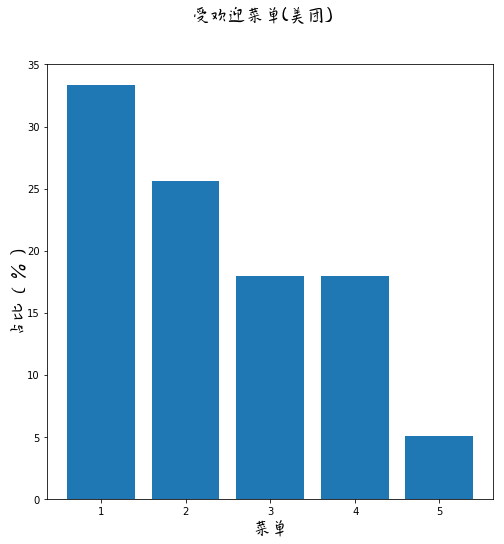

In [21]:
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

# 调整package可以显示中文
chinesefont = matplotlib.font_manager.FontProperties(fname='../fonts/HanyiSentyLotus.ttf')


fig,ax = plt.subplots()
tick_labels = ['1', '2', '3', ' 4', '5']
plt.rcParams["figure.figsize"] = (8,8)
plt.bar(range(5), comments['菜单'].value_counts()*100/len(comments['菜单']),
       tick_label=tick_labels, align='center'
       )
fig.suptitle(u'受欢迎菜单(美团)', fontproperties=chinesefont, fontsize=25)
plt.xlabel(u'菜单',fontproperties=chinesefont,fontsize=25)  
plt.ylabel(u'占比（%）',fontproperties=chinesefont,fontsize=25)  
plt.show()   

由于代码无法显示中文，我用数字表示
1.  全部菜品2选1，提供免费WiFi
2.  番茄牛腩空心面1份   
3. 单人套餐A，提供免费WiFi
4.   30元代金券1张，可叠加
5. 数据缺失

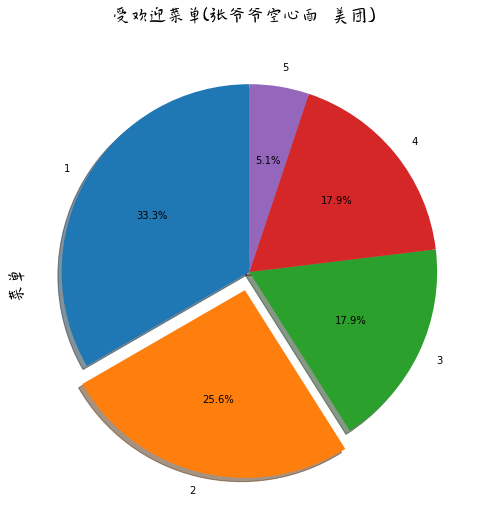

In [40]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['1', '2', '3', ' 4', '5']
sizes = comments['菜单'].value_counts()
explode = (0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
fig1.suptitle(u'受欢迎菜单(张爷爷空心面  美团)', fontproperties=chinesefont, fontsize=25) 
plt.ylabel(u'菜单',fontproperties=chinesefont,fontsize=25)  
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

由于代码无法显示中文，我用数字表示
1.  全部菜品2选1，提供免费WiFi
2.  番茄牛腩空心面1份   
3. 单人套餐A，提供免费WiFi
4.   30元代金券1张，可叠加
5. 数据缺失

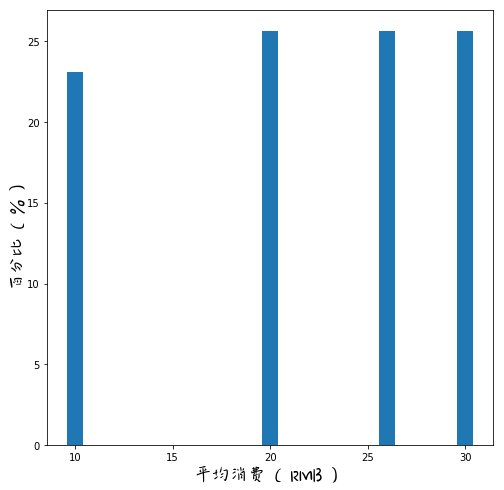

In [42]:
# fig,ax = plt.subplots()

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(comments['平均消费'].unique(),comments['平均消费'].value_counts()*100/len(comments['平均消费']))
fig.suptitle(u'顾客平均消费(美团)', fontproperties=chinesefont, fontsize=25)
plt.xlabel(u'平均消费（RMB）',fontproperties=chinesefont,fontsize=25)  
plt.ylabel(u'百分比（%）',fontproperties=chinesefont,fontsize=25)  
plt.show()   



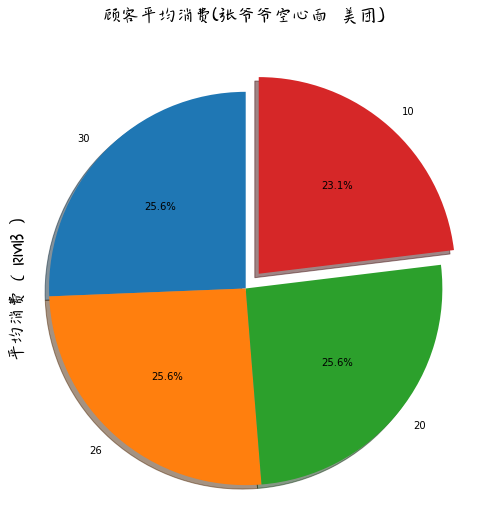

In [43]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = comments['平均消费'].unique()
sizes = comments['平均消费'].value_counts()
explode = (0, 0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
fig1.suptitle(u'顾客平均消费(张爷爷空心面  美团)', fontproperties=chinesefont, fontsize=25) 
plt.ylabel(u'平均消费（RMB）',fontproperties=chinesefont,fontsize=25)  
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

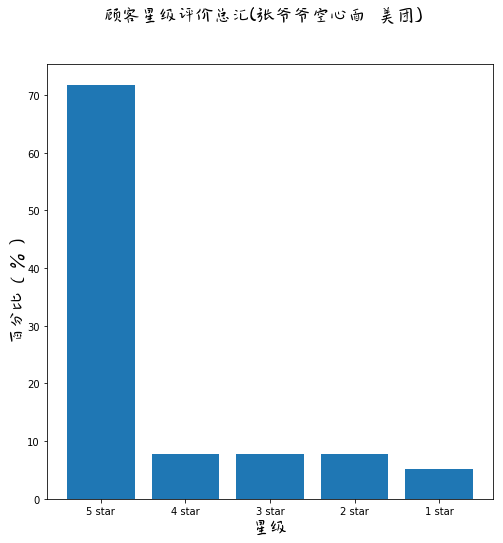

In [35]:
fig,ax = plt.subplots()

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(["5 star",'4 star','3 star','2 star','1 star'],comments['星级'].value_counts()*100/len(comments['星级']))
fig.suptitle(u'顾客星级评价总汇(张爷爷空心面  美团)', fontproperties=chinesefont, fontsize=25)
plt.xlabel(u'星级',fontproperties=chinesefont,fontsize=25)  
plt.ylabel(u'百分比（%）',fontproperties=chinesefont,fontsize=25)  
plt.show()   


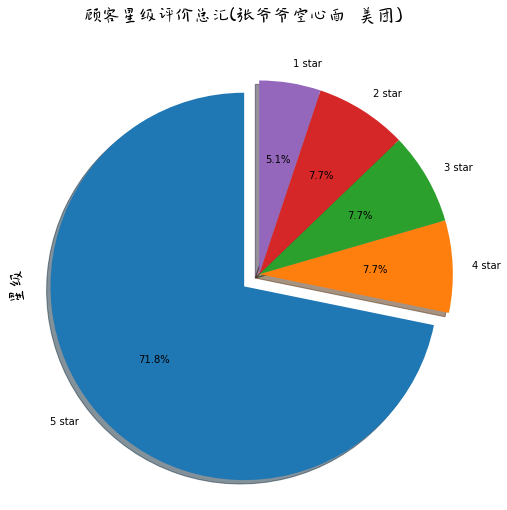

In [34]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = "5 star",'4 star','3 star','2 star','1 star'
sizes = comments['星级'].value_counts()
explode = (0.1, 0, 0, 0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
fig1.suptitle(u'顾客星级评价总汇(张爷爷空心面  美团)', fontproperties=chinesefont, fontsize=25) 
plt.ylabel(u'星级',fontproperties=chinesefont,fontsize=25)  
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()